In [ ]:
# Parallelization - run on hpc05
from hpc05 import Client
rc = Client()
lview = rc.load_balanced_view()
dview = rc[:]

In [ ]:
len(rc)

In [1]:
# %%px --local

import kwant
import scipy
import numpy as np

from types import SimpleNamespace

import Modules.pauli as pauli
import Modules.TB_parameters as Tpar
import Modules.ribbon_params_11_band as rp
import Modules.Ham_MX2_11_band as Ham
import Modules.functions as func

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
%%px --local

def decay_Exs_mus(t, params, three_d=False):
    Ex, mu = t
    params['mu'] = mu
    params['Ex'] = Ex
    flead = func.make_AC_lead(plot_sys=False, SC=True, spin=True, finalize=True, three_d=three_d)
    try:
        return func.slowest_evan_mode(flead, params)
    except:
        params['k_y'] += 1e-8
        return func.slowest_evan_mode(flead, params)
#     except np.linalg.LinAlgError:
#         params['k_y'] += 1e-8
#         return func.slowest_evan_mode(flead, params)
    
def decay_kys_Exs(t, params, three_d=False):
    ky, Ex = t
    params['k_y'] = ky
    params['Ex'] = Ex
    flead = func.make_AC_lead(plot_sys=False, SC=True, spin=True, finalize=True, three_d=three_d)
    try:
        return func.slowest_evan_mode(flead, params)
    except:
        params['k_y'] += 1e-8
        return func.slowest_evan_mode(flead, params)
#     except np.linalg.linalg.LinAlgError:
#         params['k_y'] += 1e-8
#         return func.slowest_evan_mode(flead, params)

## Decay length vs $\mu$ and $E_x$

In [ ]:
%%px --local
params = dict(k_y=1e-8, Ex=0, Ey=0, Delta=0.8e-3, mu=1.83)
params['a'] = 3.18   # Lattice constant in Å
three_d = True # Use a 2D or a 3D lattice

In [ ]:
# Sweep mu and Ex
mus = np.linspace(1.8, 1.87, 400)
sqrts = np.linspace(0, 0.03, 400)
Exs = np.sqrt(sqrts**2 + params['Delta']**2)

ps = [(Ex, mu) for Ex in Exs for mu in mus]

In [ ]:
data = lview.map_async(lambda t: decay_Exs_mus(t, params, three_d=three_d), ps)
data.wait_interactive()
out_data = data.get()

In [ ]:
import os
import pickle
path = os.path.dirname(os.path.dirname(os.getcwd())) + '/data/11_band/decay_length/'
out_name = 'Decay_Exs_mus_kpar0_Delta08meV_test3D'
# Write everything to a pickle file
with open(path + out_name + '.p', 'wb') as fp:
    pickle.dump(out_data, fp)
    pickle.dump(Exs, fp)
    pickle.dump(mus, fp)
    pickle.dump(params, fp)

## Decay length vs $k_y$ and $E_x$

Mind the scaling of the BZ

In [ ]:
%%px --local
mu = 1.83080333642  # Crossing value
params = dict(k_y=1e-8, Ex=0, Ey=0, Delta=0.8e-3, mu=mu)
params['a'] = 3.18   # Lattice constant in Å
three_d = True # Use a 2D or a 3D lattice

In [ ]:
# Sweep ky and Ex
kys = np.linspace(-0.5, 0.5, 500)*np.pi
sqrts = np.linspace(0, 0.018, 500)
Exs = np.sqrt(sqrts**2 + params['Delta']**2)

ps = [(ky, Ex) for ky in kys for Ex in Exs]

In [ ]:
data = lview.map_async(lambda t: decay_kys_Exs(t, params, three_d=three_d), ps)
data.wait_interactive()
out_data = data.get()

In [ ]:
import os
import pickle
path = os.path.dirname(os.path.dirname(os.getcwd())) + '/data/11_band/decay_length/'
out_name = 'Decay_kys_Exs_cross_mu_Delta08meV_test3D'
# Write everything to a pickle file
with open(path + out_name + '.p', 'wb') as fp:
    pickle.dump(out_data, fp)
    pickle.dump(kys, fp)
    pickle.dump(Exs, fp)
    pickle.dump(params, fp)

In [ ]:
flead = func.make_AC_lead(plot_sys=True, SC=True, spin=True, finalize=True)

In [ ]:
params

In [ ]:
params = dict(k_y=1e-8, Ex=0, Ey=0, Delta=0.8e-3, mu=1.83)
params['a'] = 3.18   # Lattice constant in Å

In [ ]:
sqrts = [2e-3, 3e-3, 4e-3, 5e-3, 6e-3]
keys = [str(sqrt) for sqrt in sqrts]
keys

In [ ]:
kys = np.linspace(-0.6, 0.6, 500)*np.pi

In [ ]:
d_dict = {}
for sqrt, key in zip(sqrts, keys):
    Ex = np.sqrt(sqrt**2 + params['Delta']**2)
    params['Ex'] = Ex
    decay_lengths = []
    for ky in kys:
        try:
            params['k_y'] = ky 
            decay_lengths.append(func.slowest_evan_mode(flead, params))
        except np.linalg.LinAlgError:
            params['k_y'] = ky + 1e-8
            decay_lengths.append(func.slowest_evan_mode(flead, params))
    d_dict[key] = decay_lengths

In [ ]:
import os
import pickle
path = os.path.dirname(os.path.dirname(os.getcwd())) + '/data/11_band/decay_length/'

out_name = 'decay_length_armchair_kpars_sqrts_mu183'
# Write everything to a pickle file
with open(path + out_name + '.p', 'wb') as fp:
    pickle.dump(d_dict, fp)
    pickle.dump(kys, fp)
    pickle.dump(sqrts, fp)
    pickle.dump(keys, fp)
    pickle.dump(params, fp)

In [ ]:
for key in keys:
    plt.plot(kys, np.array(d_dict[key])*params['a']*1e-4, label=key)
    plt.legend()
plt.ylim(0, 15)

In [3]:
# Parallelization
import ipyparallel
rc = ipyparallel.Client()  # interface for activated engines (threads)
lview = rc.load_balanced_view()  # Use LoadBalancedView - automatic distribution of work to engines
dview = rc[:]  # DirectView to execute commands on all engines

In [4]:
len(rc)

20

In [5]:
%%px --local
import kwant
import scipy
import numpy as np

from types import SimpleNamespace

import Modules.pauli as pauli
import Modules.TB_parameters as Tpar
import Modules.ribbon_params_11_band as rp
import Modules.Ham_MX2_11_band as Ham
import Modules.functions as func

In [19]:
%%px --local

def decay_kys(ky, params, R1=2, R2=2, three_d=False):
    params['k_y'] = ky
    flead = func.make_AC_lead(R1=R1, R2=R2, plot_sys=False, SC=True, spin=True,
                              finalize=True, three_d=three_d)
    try:
        return func.slowest_evan_mode(flead, params)
    except:
        params['k_y'] += 1e-8
        return func.slowest_evan_mode(flead, params)

In [20]:
%%px --local
params = dict(k_y=1e-8, Ex=0, Ey=0, Delta=0.8e-3, mu=1.8337)
sqrt = 0.0015
Ex = np.sqrt(sqrt**2 + params['Delta']**2)
R1, R2 = 2, 1
params['R'] = (R1, R2)
params['Ex'] = Ex
params['a'] = 3.18   # Lattice constant in Å

In [21]:
kys = np.linspace(-0.75, 0.75, 20000)

In [22]:
data = lview.map_async(lambda ky: decay_kys(ky, params, R1=R1, R2=R2), kys)
data.wait_interactive()
dat = data.get()

20000/20000 tasks finished after  216 s
done


In [24]:
import os
import pickle
path = os.path.dirname(os.path.dirname(os.getcwd())) + '/data/11_band/decay_length/'

out_name = 'decay_length_armchair_kpars_sqrt1,5meV_mu18337'
# Write everything to a pickle file
with open(path + out_name + '.p', 'wb') as fp:
    pickle.dump(dat, fp)
    pickle.dump(kys, fp)
    pickle.dump(params, fp)

(0, 7)

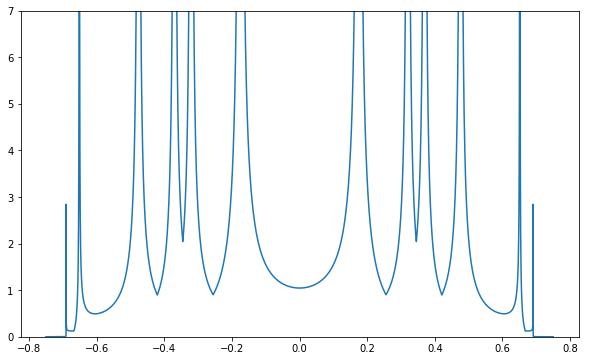

In [23]:
fig = plt.figure(figsize=(10, 6))
plt.plot(kys, np.array(dat)*params['a']*1e-4)
plt.ylim(0, 7)
# *dl_params['a']*1e-4

(0, 7)

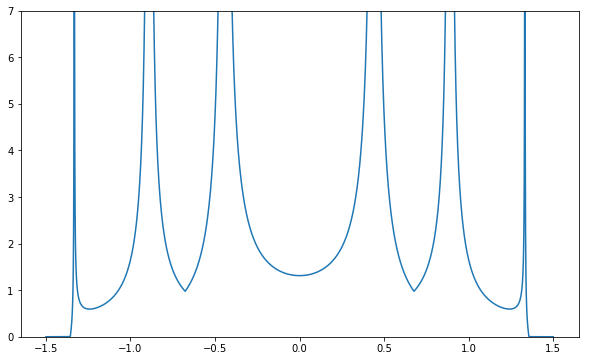

In [69]:
fig = plt.figure(figsize=(10, 6))
plt.plot(kys, np.array(dat)*params['a']*1e-4)
plt.ylim(0, 7)
# *dl_params['a']*1e-4

In [19]:
(-1.5/(2*np.sqrt(3)), 1.5/(2*np.sqrt(3)))

(-0.43301270189221935, 0.43301270189221935)